Test the relationship between BCM rule and ICA


1. Generate sample s from identified independent resources (Laplace distribution) large enough sample size
2. Generate random mixing matrix A 2*2
3. Generate data samples $ s_{rt} = As $
4. Use sklearn, fast ICA, see weights and reconstruct the input: $ s_{rc} = ws_{rt} $
5. Use ICA objective function, see weights and outputs
6. Use BCM learning rule,see weights and outputs


In [136]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
import pandas as pd
% matplotlib inline
import BCM

In [112]:
# Define BCM class by quadratic local learning rule
# Relu activation function
# Update weight per sample
# Enable batch normalization

class BCM:
    """BCM learning
    Parameter:
    eta: float, learning rate (between 0.0 - 1.0)
    n_iter: int, passes over the training dataset
    ny: number of output neurons
    batchsize: float, percentage of data that are used to update the weight once
    
    Attributes:
    w_: 1d-array, weights after fitting
    error_: list, number of misclassification in every epoch
    """
    def __init__(self, eta = 0.1,n_epoch = 10,ny = 1,batch = 10, tau = 100,thres = 0, p = 2,random_state = None, shuffle = True,nonlinear = None):
        self.eta = eta
        self.n_epoch = n_epoch
        self.ny = ny
        self.tau = tau  # Time constant for calculating thresholds
        self.thres = [thres*np.ones(ny)]
        self.p = p    # int, power for threshold computation
        self.y_thres = []      # Storaged y for studying effect of threshold
        self.shuffle = shuffle
        self.nonlinear = nonlinear
        self.batch = batch
        
        if random_state:
            seed(random_state)
            
    def fit(self,X):
        """fitting training data
        Parameter:
        X: {array-like}, shape = [n_samples,n_features]
        Returns: self:object
        ny: value, number of output neurons
        """
        # Weights initialized as normal distribution
        self.w_ = np.random.randn(X.shape[1],self.ny) # 2*1
        self.w_track = []
        
        # Use elementwise training 
        threshold = np.zeros(2)
        for _ in range(self.n_epoch):
            if self.shuffle:
                X = self._shuffle(X)
            if self.batch:
                X_batch = []
                for k in range(0,X.shape[0],self.batch):
                    X_batch.append(np.mean(X[k:k+self.batch,:],axis = 0))
                X_batch = np.vstack(X_batch)
            for i, xi in enumerate(X_batch):   # elementwise training for all samples
                theta = np.zeros(2)
                y = np.zeros(2)
                for j in range(self.ny):
                    y[j] = np.dot(xi,self.w_[:,j])
                    if self.nonlinear == 'Sigmoid':
                        y[j] = self._sigmoid (y[j])
                    elif self.nonlinear == 'Relu':
                        y[j] = (1-(y[j]<0))* y[j]
                    self.w_[:,j][:,None] = self.w_[:,j][:,None]+ self.eta * xi[:,None]* y[j]*(y[j] - threshold[j])
                    h = np.exp(-1/self.tau)
                    y_power = y[j]**2
                    theta[j] = threshold[j]*h+y_power*(1-h)  # Good way to implement exponential moving average
                w_tmp = np.concatenate(self.w_.T, axis=0)    # make 2*2 matrix into 1*4, preparing for weight tracking
                self.y_thres.append(y)
                self.thres.append(theta)
                self.w_track.append(w_tmp.tolist())
                threshold = theta
        return self
    
    def _shuffle(self,X):
        r = np.random.permutation(len(X))
        return X[r]
    
    def _sigmoid(self,z):
        return 1/(1+np.exp(-z))

Generate sample from laplace distribuction: $p(s_{i}(t))\propto exp(-\sqrt2|s_{i}|)$

Here we will simulation the effect of two neurons seperating to independent sources. The mixing matrix will be an rotation matrix $A = (cos\theta, -sin\theta;sin\theta,cos\theta)$

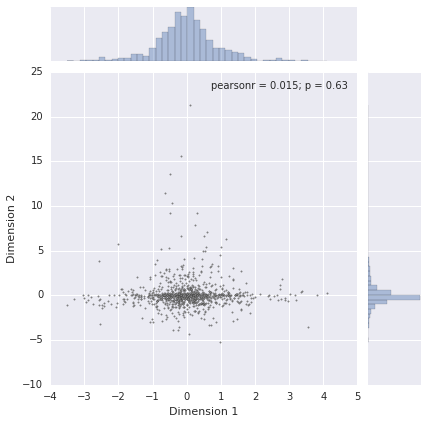

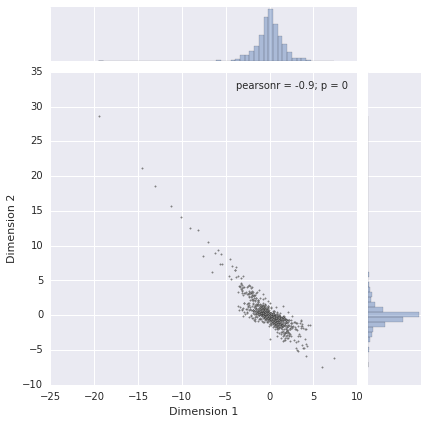

In [113]:
# Sample from the above distribution
loc = 0   # Mean zero
scale = (2**0.5)**(-1)
s = np.random.laplace(loc,scale,[1000,2])  # 5000*2, 0 mean, unit variance

# make data skewed with a half-squaring
idx = s[:,1] > 0
s[idx,1] = s[idx,1]**2

# Conduct rotation and mixture
# Generate rotation matrix
theta = np.pi/4      # 45 degree rotation
#A = np.array(((mt.cos(theta),-mt.sin(theta)),(mt.sin(theta),mt.cos(theta))))
A = np.random.randn(2,2)
#A = np.dot(A, A.T)

s_rt = np.dot(s,A)

# plot original distribution
df = pd.DataFrame({'x':s[:,0],'y':s[:,1]})
g = sns.jointplot(x="x", y="y", data=df)
g.plot_joint(plt.scatter, c="gray", s=10, linewidth=.1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Dimension 1", "Dimension 2")



# plot mixed distribution
df = pd.DataFrame({'x':s_rt[:,0],'y':s_rt[:,1]})
g = sns.jointplot(x="x", y="y", data=df)
g.plot_joint(plt.scatter, c="gray", s=10, linewidth=.1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Dimension 1", "Dimension 2")


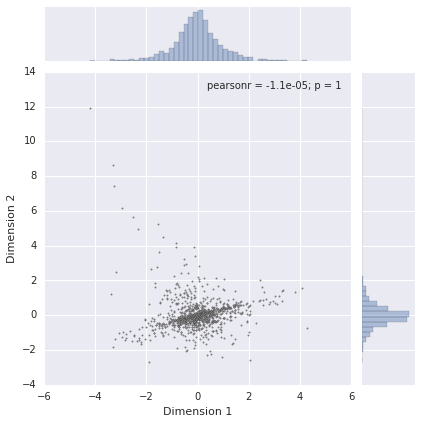

In [114]:
# Perform zca whitening
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    #ZCAMatrix = np.dot(U, np.diag(1.0/np.sqrt(S + epsilon))) # [M x M]
    return ZCAMatrix

ZCAMatrix = zca_whitening_matrix(s_rt.T)
s_rt_wt = np.dot(s_rt,ZCAMatrix)
# Generate 2d satter plot of the whitened data
df = pd.DataFrame({'x':s_rt_wt[:,0],'y':s_rt_wt[:,1]})
g = sns.jointplot(x="x", y="y", data=df)
g.plot_joint(plt.scatter, c="gray", s=10, linewidth=.1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Dimension 1", "Dimension 2")


done in 1.841s


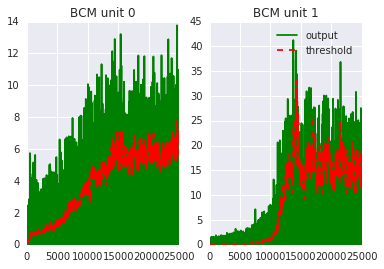

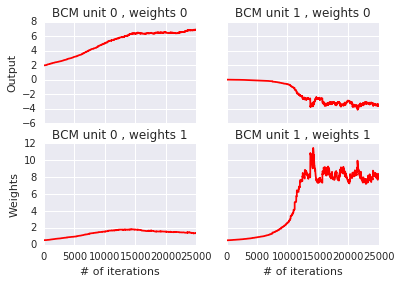

In [132]:
# Train BCM model with Laplace data

ny = 2    # 2 output neurons
n_epoch = 100
p = 2
eta = 0.0005
tau = 200
batch = 4
BCM_laplace = BCM(eta = eta,n_epoch = n_epoch,batch = batch,ny = ny,tau = tau, thres = 0, p = p,random_state = None, shuffle = True, nonlinear = 'Relu')

t0 = time()
BCM_laplace.fit(s_rt_wt)
print("done in %0.3fs" % (time()-t0))

#x_plot = range(n_iter * len(X))
plt_range = n_epoch * len(s_rt_wt)
BCM_laplace_thres = np.vstack(BCM_laplace.thres)
BCM_laplace_out = np.vstack(BCM_laplace.y_thres)
BCM_laplace_w = np.vstack(BCM_laplace.w_track)

n_row = 1
n_column = ny

BCM_laplace_titles= ["BCM unit %d" % i for i in range (ny)]
# Plot y and threshold
for i in range(ny):
    plt.subplot(n_row,n_column,i+1)
    plt.plot(BCM_laplace_out[:plt_range,i],'g-',label = 'output')
    plt.plot(BCM_laplace_thres[:plt_range,i],'r--',label = 'threshold')
    plt.title(BCM_laplace_titles[i])

plt.legend(loc = 'upper right')

plt.figure()
# Plot weights

BCM_laplace_titles= ["BCM weights %d" % i for i in range (len(BCM_laplace_w.T))]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(BCM_laplace_w[:,0],'r',label = 'weight')
ax1.set_ylabel('Output')
ax1.set_title("BCM unit %d , weights %d" % (0,0))
ax2.plot(BCM_laplace_w[:,2],'r',label = 'weight')
ax2.set_title("BCM unit %d , weights %d" % (1,0))
ax3.plot(BCM_laplace_w[:,1],'r',label = 'weight')
ax3.set_title("BCM unit %d , weights %d" % (0,1))
ax3.set_xlabel('# of iterations')
ax3.set_ylabel('Weights')
ax4.plot(BCM_laplace_w[:,3],'r',label = 'weight')
ax4.set_title("BCM unit %d , weights %d" % (1,1))
ax4.set_xlabel('# of iterations')

[[ 6.86710944 -3.55288349]
 [ 1.37422375  7.99182452]]


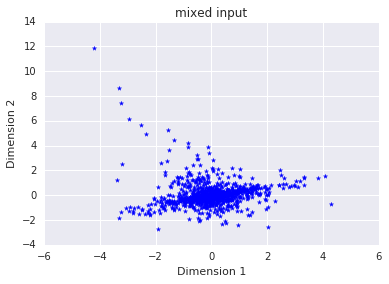

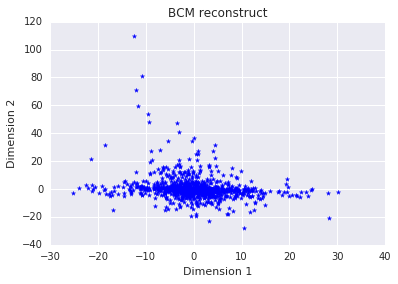

In [133]:
print(BCM_laplace.w_)

# Use the weights to reconstruct the input
s_rc = np.dot(s_rt_wt,BCM_laplace.w_)

# Generate 2d satter plot of the input data
plt.scatter(s_rt_wt[:,0],s_rt_wt[:,1],color = 'blue', marker = '*')
plt.xlabel ('Dimension 1')
plt.ylabel ('Dimension 2')
plt.title('mixed input')
plt.figure()
# Generate 2d satter plot of the reconstructed data
plt.scatter(s_rc[:,0],s_rc[:,1],color = 'blue', marker = '*')
plt.xlabel ('Dimension 1')
plt.ylabel ('Dimension 2')
plt.title('BCM reconstruct')

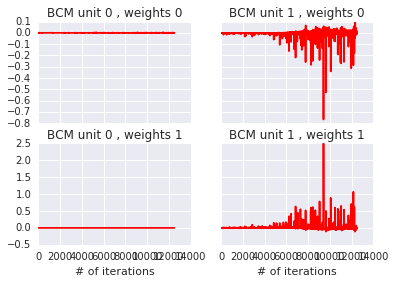

In [121]:
# Prepare for using tol for determining the number of epochs
# Prepare for using tol for determining the learning rate

# Calculate maximum weight difference
diff_w = np.diff(BCM_laplace_w,axis = 0)
diff_w = np.vstack([np.zeros(4),diff_w])
diff_w_norm = np.divide(diff_w,BCM_laplace_w)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(diff_w [:,0],'r',label = 'weight')
ax1.set_title("BCM unit %d , weights %d" % (0,0))
ax2.plot(diff_w [:,2],'r',label = 'weight')
ax2.set_title("BCM unit %d , weights %d" % (1,0))
ax3.plot(diff_w [:,1],'r',label = 'weight')
ax3.set_title("BCM unit %d , weights %d" % (0,1))
ax3.set_xlabel('# of iterations')
ax4.plot(diff_w [:,3],'r',label = 'weight')
ax4.set_title("BCM unit %d , weights %d" % (1,1))
ax4.set_xlabel('# of iterations')

Extracting the top 2 ica components from 1000 samples
done in 0.002s


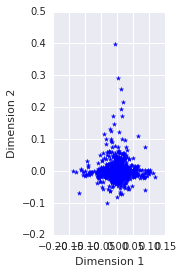

In [134]:
# Use fast ICA and see weights and results

from sklearn.decomposition import FastICA
from time import time
# Compute the ICA (eigendigits) on the digits
n_components = 2

print("Extracting the top %d ica components from %d samples" % (n_components,s_rt.shape[0]))
t0 = time()
ica_s = FastICA(n_components = n_components, whiten = True).fit(s_rt_wt)
print("done in %0.3fs" % (time()-t0))

# Use the weights to reconstruct the input
w = ica_s.components_
s_rc = np.dot(s_rt_wt,w)

# Generate 2d satter plot of the reconstructed data
plt.scatter(s_rc[:,0],s_rc[:,1],color = 'blue', marker = '*')
plt.xlabel ('Dimension 1')
plt.ylabel ('Dimension 2')
plt.gca().set_aspect(1)

In [40]:
range?

In [76]:
# Train BCM model with Laplace data

ny = 2    # 2 output neurons
n_epoch = 1
p = 2
eta = 0.0001
tau = 200
BCM_laplace = BCM_batch(eta = eta,n_epoch = n_epoch,batch =1,ny = ny,tau = tau, thres = 0, p = p,random_state = None, shuffle = True, nonlinear = 'Relu')

BCM_laplace.fit(s_rt_wt[:20])

[[-0.48612208  0.61210988]
 [-0.14198909  2.06575525]
 [-0.12688232  0.48474728]
 [ 1.1799598  -0.61250209]
 [-1.94393845 -0.43279147]
 [ 0.53684119  0.94898354]
 [-0.01243306 -0.11536168]
 [ 0.60198517  0.89266314]
 [ 0.9495988   0.07430715]
 [ 0.86232491  0.27975895]
 [-0.06716427  0.95193125]
 [ 2.40933146  0.71781176]
 [ 2.09358093  0.17253717]
 [-0.30136853 -0.74084312]
 [ 0.02186242 -0.12817953]
 [ 0.35140926  0.74900373]
 [-0.04866737  0.0531535 ]
 [-0.26403206  0.92443957]
 [-0.01752763 -0.34240618]
 [-0.2468968  -0.51459667]]
[[-0.48612208  0.61210988]
 [-0.14198909  2.06575525]
 [-0.12688232  0.48474728]
 [ 1.1799598  -0.61250209]
 [-1.94393845 -0.43279147]
 [ 0.53684119  0.94898354]
 [-0.01243306 -0.11536168]
 [ 0.60198517  0.89266314]
 [ 0.9495988   0.07430715]
 [ 0.86232491  0.27975895]
 [-0.06716427  0.95193125]
 [ 2.40933146  0.71781176]
 [ 2.09358093  0.17253717]
 [-0.30136853 -0.74084312]
 [ 0.02186242 -0.12817953]
 [ 0.35140926  0.74900373]
 [-0.04866737  0.0531535 ]


With ICA, a scalar factor is missing, but obtained the correct weight direction to demix the inputs